# **model_XGBoost_3.0** for XRP

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import joblib
from datetime import datetime

# 데이터 로드 및 변환
data = pd.read_csv('xrp_data_2024_latest_2.csv') # 데이터 3056개
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 피처와 타겟 분리
features = data.drop(columns=['timestamp', 'target_close'])
target = data['target_close']

# 시계열 데이터 분리
train_size = int(len(data) * 0.8)
X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

# 가중치 부여 (최신 데이터에 높은 가중치)
train_indices = range(len(X_train))
weights = [1 + 2 * (i / len(train_indices)) for i in train_indices]

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#joblib.dump(scaler, 'scaler_3.0.pkl')

# 모델 초기화
model = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 모델 학습 (가중치 추가)
model.fit(X_train_scaled, y_train, sample_weight=weights)

# 모델 저장
#joblib.dump(model, 'model_XGBoost_3.0.pkl')
from sklearn.metrics import r2_score
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

R² Score: 0.9567573721722809


# **model_LSTM_4.0** for XRP

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2065 - val_loss: 0.0833
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - val_loss: 0.0807
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - val_loss: 0.0340
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 - val_loss: 0.0353
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0156
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - val_loss: 0.0158
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0152
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0126
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0085
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0145
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0056


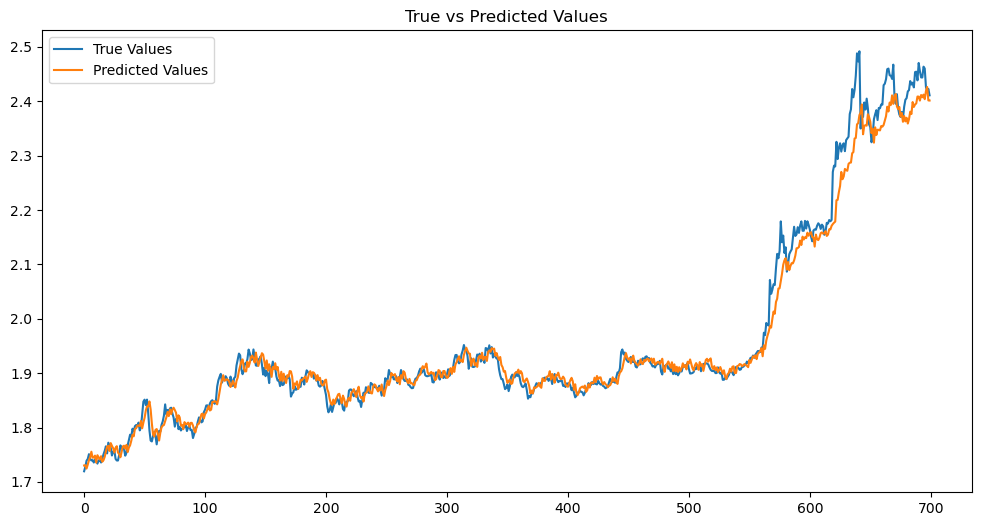

In [148]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

data = pd.read_csv('xrp_data_2024_latest_3.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

features = data.drop(columns=['timestamp', 'target_close'])
target = data['target_close']

train_size = int(len(data) * 0.8)
X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'XRP_scaler_LSTM_4.0.pkl')

# 시계열 데이터 생성 함수
def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# 시계열 데이터 생성
time_steps = 5
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, time_steps)

# LSTM 모델 정의
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 예측 및 평가
y_pred = model.predict(X_test_seq)
r2 = r2_score(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)

print(f"R² Score: {r2}")
print(f"Test MSE: {mse}")

# 모델 저장
#joblib.dump(model, 'XRP_model_LSTM_4.0.pkl')
#model.save('XRP_model_LSTM_4.0.keras')

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.show()

# **model_LSTM_6.0** for XRP

Epoch 1/70


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3269 - val_loss: 0.0390
Epoch 2/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126 - val_loss: 0.0654
Epoch 3/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0101 - val_loss: 0.0687
Epoch 4/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0079 - val_loss: 0.0794
Epoch 5/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078 - val_loss: 0.0460
Epoch 6/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - val_loss: 0.0198
Epoch 7/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - val_loss: 0.0232
Epoch 8/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 9/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063 - val_loss: 0.0121
Epoch 10/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - val_loss: 0.0227
Epoch 11/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - val_loss: 0.0185
Epoch 12/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 - val_loss: 0.0034


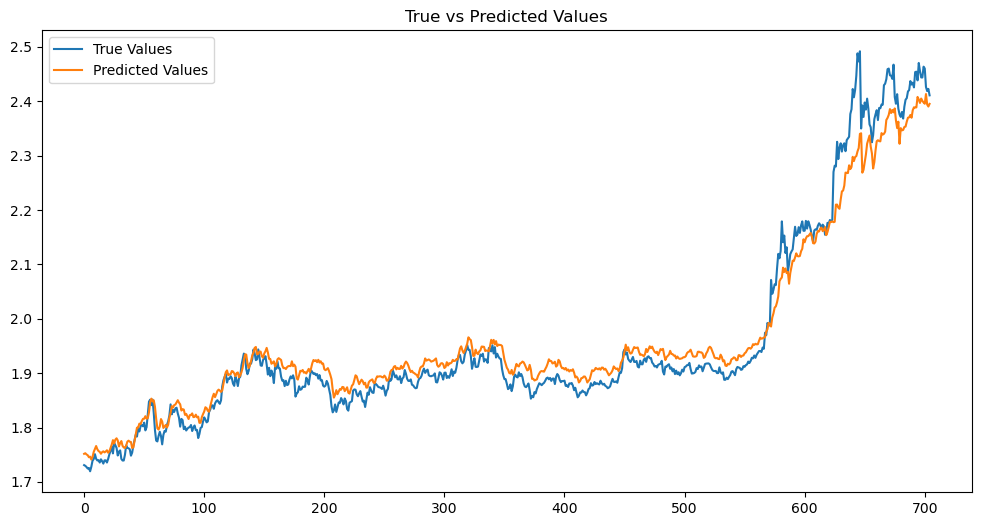

In [227]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv('xrp_data_2024_latest_3.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 피처와 타겟 분리
features = data.drop(columns=['timestamp', 'target_close'])
target = data['target_close']

# Train-Test Split
train_size = int(len(data) * 0.8)
X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

# Scaler 정의 및 학습
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
joblib.dump(scaler, 'XRP_scaler_LSTM_6.0.pkl')

# 시계열 데이터 생성 함수 (time_steps=1)
def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X.iloc[i:i + time_steps].values.flatten())  # 1D로 변환
        y_seq.append(y.iloc[i + time_steps - 1])
    return np.array(X_seq), np.array(y_seq)

# 시계열 데이터 생성
time_steps = 1
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

# LSTM 모델 정의
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, X_train_seq.shape[1])),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_seq.reshape(-1, 1, X_train_seq.shape[1]),  # (batch_size, time_steps=1, features)
    y_train_seq,
    validation_data=(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]), y_test_seq),
    epochs=70,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 예측 및 평가
y_pred = model.predict(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]))
r2 = r2_score(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)

print(f"R² Score: {r2}")
print(f"Test MSE: {mse}")

# 모델 저장
model.save('XRP_model_LSTM_6.0.keras')

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.show()

# **model_LSTM_7.0** for XRP

Epoch 1/70


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1516 - val_loss: 0.0454 - learning_rate: 0.0100
Epoch 2/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0396 - learning_rate: 0.0100
Epoch 3/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0253 - learning_rate: 0.0100
Epoch 4/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0072 - learning_rate: 0.0100
Epoch 5/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0127 - learning_rate: 0.0100
Epoch 6/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0059 - learning_rate: 0.0100
Epoch 7/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0071 - learning_rate: 0.0100
Epoch 8/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0032 - learning_rate: 0.0100
Epoch 9/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0037 - learning_rate: 0.0100
Epoch 10/70
127/127 ━

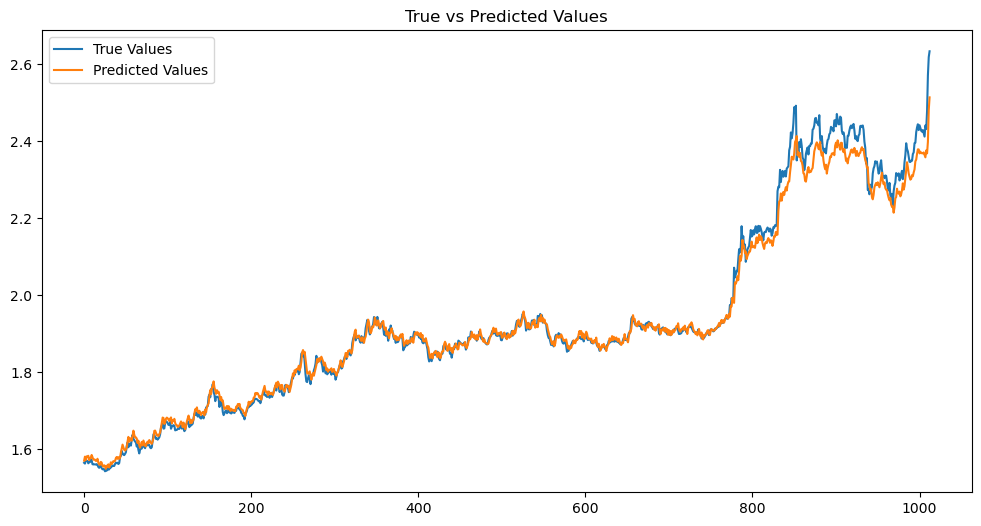

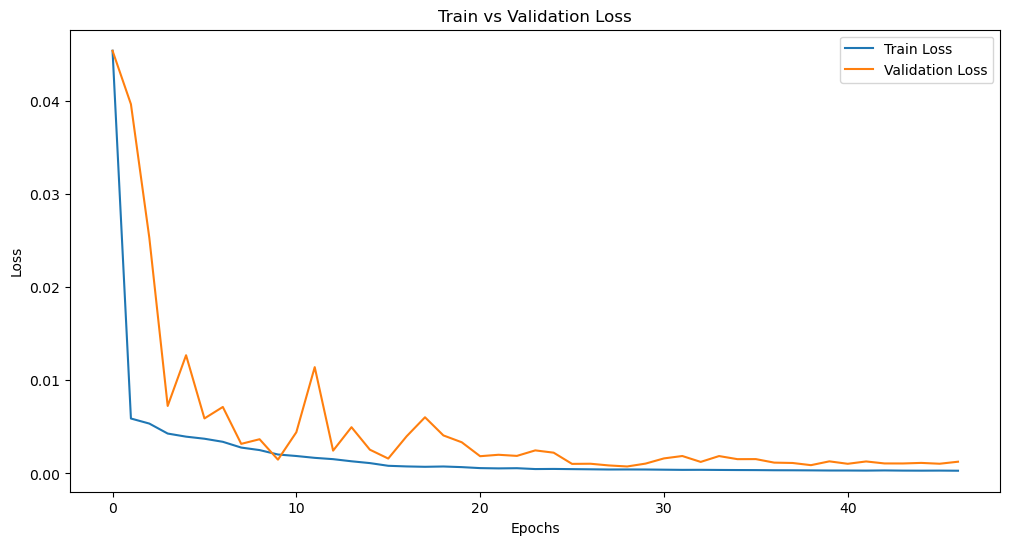

In [320]:
import os
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt

# 난수 설정 함수
def set_seed(seed=7):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# 난수 고정
set_seed(7)

data = pd.read_csv('xrp_data_2024_latest_4.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

features = data.drop(columns=['timestamp', 'target_close'])
target = data['target_close']

train_size = int(len(data) * 0.8)
X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
#joblib.dump(scaler, 'XRP_scaler_LSTM_7.0.pkl')

# 시계열 데이터 생성 함수 (time_steps=1)
def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X.iloc[i:i + time_steps].values.flatten())  # 1D로 변환
        y_seq.append(y.iloc[i + time_steps - 1])
    return np.array(X_seq), np.array(y_seq)

# 시계열 데이터 생성
time_steps = 1
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

# LSTM 모델 정의
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(1, X_train_seq.shape[1])),
    Dropout(0.4),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# learning rate 감소
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_seq.reshape(-1, 1, X_train_seq.shape[1]),  # (batch_size, time_steps=1, features)
    y_train_seq,
    validation_data=(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]), y_test_seq),
    epochs=70,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# 예측 및 평가
y_pred = model.predict(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]))
r2 = r2_score(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)

print(f"R² Score: {r2}")
print(f"Test MSE: {mse}")

# 모델 저장
#model.save('XRP_model_LSTM_7.0.keras')

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.show()

# 과적합 여부 판단
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()